In [1]:
import argparse
import pickle
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from custom_environment import *
from pandas_datareader.data import DataReader

In [2]:
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

In [3]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

In [4]:
class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))

        return x

In [5]:
class Memory():

    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)

In [6]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))

        return x


class Memory():

    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)


class DDPGAgent():

    max_grad_norm = 0.5

    def __init__(self, env, hidden_size=256, gamma=0.9, cuda=False):
        self.gamma = gamma
        self.env = env
        self.training_step = 0
        self.var = 1.
        self.cuda = cuda

        if len(env.observation_space.shape) == 2: # 2d input
            self.num_states = env.observation_space.shape[0] * env.observation_space.shape[1]
        else:
            self.num_states = env.observation_space.shape[0]

        self.num_actions = env.action_space.shape[0]

        self.eval_cnet, self.target_cnet = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions).float(), Critic(self.num_states + self.num_actions, hidden_size, self.num_actions).float()
        self.eval_anet, self.target_anet = Actor(self.num_states, hidden_size, self.num_actions).float(), Actor(self.num_states, hidden_size, self.num_actions).float()
        self.memory = Memory(2000)
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)

        if cuda:
            self.eval_cnet = self.eval_cnet.cuda()
            self.target_cnet = self.target_cnet.cuda()
            self.eval_anet = self.eval_anet.cuda()
            self.target_anet = self.target_anet.cuda()

    def select_action(self, state):
        if self.cuda:
            state = torch.from_numpy(state).cuda().float().unsqueeze(0)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state).cpu()
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))
        action = dist.sample()
        action.clamp(0, 1)
        return (action.detach().numpy(),)

    def save_param(self):
        torch.save(self.eval_anet.state_dict(), 'param/ddpg_anet_params.pkl')
        torch.save(self.eval_cnet.state_dict(), 'param/ddpg_cnet_params.pkl')

    def store_transition(self, transition):
        self.memory.update(transition)

    def update(self, batch_size):
        self.training_step += 1

        transitions = self.memory.sample(batch_size)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float).view(-1, self.num_actions)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        if self.cuda:
            s = s.cuda()
            a = a.cuda()
            r = r.cuda()
            s_ = s_.cuda()


        with torch.no_grad():
            q_target = r + self.gamma * self.target_cnet(s_, self.target_anet(s_))
        q_eval = self.eval_cnet(s, a)

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean()
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()


In [7]:
print('loading data')
data = DataReader('GOGL', 'yahoo', start='2000-01-01', end='2021-01-01')

print(data.describe())


test_data = data.tail(365)
train_data = data.head(-365)

print(len(train_data))

loading data
              High          Low         Open        Close        Volume  \
count  5285.000000  5285.000000  5285.000000  5285.000000  5.285000e+03   
mean     71.977223    69.307737    70.737365    70.635272  9.312302e+04   
std      54.467648    52.628059    53.671556    53.556911  1.316300e+05   
min       2.770000     2.520000     2.650000     2.550000  5.000000e+02   
25%      13.700000    12.850000    13.350000    13.300000  2.362000e+04   
50%      70.900002    68.349998    69.650002    69.550003  4.330000e+04   
75%     114.949997   110.849998   113.099998   112.849998  1.042800e+05   
max     237.500000   231.500000   235.000000   234.750000  2.127300e+06   

         Adj Close  
count  5285.000000  
mean     31.200699  
std      22.912915  
min       2.328791  
25%      10.283531  
50%      24.550537  
75%      51.769726  
max      87.927231  
4920


In [8]:
env = CustomStockEnv(
    stock_df = train_data,
    pred_df = train_data,
    window_size = 14,
    initial_balance = 5000,
    min_percent_loss = .5,
    with_pred=False
    )

test_env = CustomStockEnv(
    stock_df = test_data,
    pred_df = test_data,
    window_size = 14,
    initial_balance = 5000,
    min_percent_loss = .5,
    with_pred=False,
    test_env=True,
    train_df=train_data
    )

This is a testing environment, scaling based on training data.
C:\Python38\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
C:\Python38\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
log_interval = 10

In [12]:
agent = DDPGAgent(env, cuda=True)

Step 0	Average score: -10203.52	Average Q: -0.00
Step 10	Average score: -2075.71	Average Q: 11.60
Step 20	Average score: -10218.63	Average Q: 10.40
Step 30	Average score: -23698.26	Average Q: -3.68
Step 40	Average score: -27541.85	Average Q: -31.50


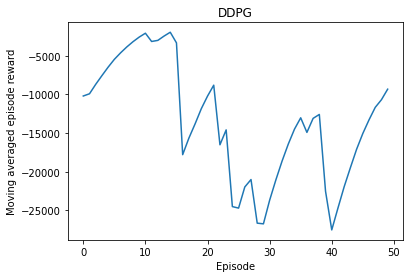

In [17]:
training_records = []
running_reward, running_q = -1000, 0
for i_ep in range(50):
    score = 0
    state = env.reset()
    state = state.to_numpy().reshape(-1)
    for t in range(2000):
        action = agent.select_action(state)[0]
        state_, reward, done, _ = env.step(action[0])
        score += reward
        # if args.render:
        #     env.render()
        state_ = state_.to_numpy().reshape(-1)
        agent.store_transition(Transition(state, action, (reward + 8) / 8, state_))
        state = state_
        if agent.memory.isfull:
            q = agent.update(128)
            running_q = 0.99 * running_q + 0.01 * q

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainingRecord(i_ep, running_reward))

    if i_ep % log_interval == 0:
        print('Step {}\tAverage score: {:.2f}\tAverage Q: {:.2f}'.format(
            i_ep, running_reward, running_q))
    if running_reward > 1000:
        print("Solved! Running reward is now {}!".format(running_reward))
        env.close()
        # agent.save_param()
        # with open('log/ddpg_training_records.pkl', 'wb') as f:
        #     pickle.dump(training_records, f)
        break

env.close()

plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('DDPG')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
# plt.savefig("ddpg.png")
plt.show()

In [15]:
state = test_env.reset()
while True:
    action = agent.select_action(state.to_numpy().reshape(-1))[0]
    state_, reward, done, _ = test_env.step(action[0])
    state = state_

    if done:
        test_env.render()
        # state = env.reset()
        break

mode: without preditions
Step: 14
initial_balance: 5000
min_balance: 2500.0
Balance: 2.4074205339229593
Shares held: 2852 (Total sold: 104422)
Avg cost for held shares: 4.2728616176579575 (Total sales value: 403527.0909104166)
Net worth: 12785.394478764953 (Max net worth: 12791.768153902854)
Profit: 7785.3944787649525


In [36]:
torch.save(agent.eval_cnet.state_dict(),'models/ddpg_eval_cnet.pt')
torch.save(agent.target_cnet.state_dict(),'models/ddpg_target_cnet.pt')
torch.save(agent.eval_anet.state_dict(),'models/ddpg_eval_anet.pt')
torch.save(agent.target_anet.state_dict(),'models/ddpg_target_anet.pt')

In [11]:
agent = DDPGAgent(env, cuda=False)

In [12]:
agent.eval_cnet.load_state_dict(torch.load('models/ddpg_eval_cnet.pt', map_location=torch.device('cpu')))
agent.target_cnet.load_state_dict(torch.load('models/ddpg_target_cnet.pt', map_location=torch.device('cpu')))
agent.eval_anet.load_state_dict(torch.load('models/ddpg_eval_anet.pt', map_location=torch.device('cpu')))
agent.target_anet.load_state_dict(torch.load('models/ddpg_target_anet.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
profits = []
sims = 10

sim_infos = []

for i in range(sims):
    infos = []
    obs = test_env.reset()
    while True:
        action = agent.select_action(obs.to_numpy().reshape(-1))[0]
        obs_, reward, done, info = test_env.step(action[0])
        obs = obs_
        infos.append(info)
        if done: 
            profits.append(info['profit'])
            # test_env.render()
            sim_infos.append(infos)
            break

    

    print('finished sim %d/%d'%(i+1,sims))

pos_count = len(list(filter(lambda x: (x >= 0), profits))) 
print('made profit - ' + str(pos_count/len(profits)))

finished sim 1/10
finished sim 2/10
finished sim 3/10
finished sim 4/10
finished sim 5/10
finished sim 6/10
finished sim 7/10
finished sim 8/10
finished sim 9/10
finished sim 10/10
made profit - 0.5


In [21]:
print('Our method (DDPG)')

end_point_net_worth = []

for run in sim_infos:
        end_point_net_worth.append(run[-1]['net_worth'])
        
max_run = np.argmax(end_point_net_worth)

print('Results for {} days'.format(365))
print('Max Net Worth: {}'.format(end_point_net_worth[max_run]))
print('Mean Net Worth: {}'.format(np.mean(end_point_net_worth)))
print('Max ROI: {}'.format(np.mean((end_point_net_worth[max_run])-5000) / 5000))
print('Mean ROI: {}'.format((np.mean(end_point_net_worth) - 5000) / 5000))

Our method (DDPG)
Results for 365 days
Max Net Worth: 9488.604921888713
Mean Net Worth: 5459.23668302412
Max ROI: 0.8977209843777426
Mean ROI: 0.09184733660482397
